# Quadratic Programs

## Introduction

In this tutorial, we briefly introduce how to build optimization problems using Qiskit's optimization module.
Qiskit introduces the `QuadraticProgram` class to make a model of an optimization problem.
More precisely, it deals with quadratically constrained quadratic programs given as follows:

$$
\begin{align}
\text{minimize}\quad& x^\top Q_0 x + c^\top x\\
\text{subject to}\quad& A x \leq b\\
& x^\top Q_i x + a_i^\top x \leq r_i, \quad 1,\dots,i,\dots,q\\
& l_i \leq x_i \leq u_i, \quad 1,\dots,i,\dots,n,
\end{align}
$$

where the $Q_i$ are $n \times n$ matrices, $A$ is a $m \times n$ matrix , $x$, and $c$ are $n$-dimensional vectors, $b$ is an $m$-dimensional vector, and where $x$ can defined as binary, integer, or continuous variables.
In addition to "$\leq$" constraints 'QuadraticProgram' also supports "$\geq$" and "$=$".

Some general info about linnear programming.
Linear programs are problems that can be expressed in canonical form as:

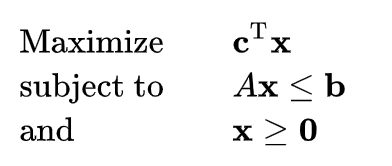


where x represents the vector of variables (to be determined), c and b are vectors of (known) coefficients, A is a (known) matrix of coefficients, and (.)^T is the matrix transpose.

## Loading a `Quadratic Program` from an LP file

As setup, you need to import the following module.

In [6]:
from qiskit.optimization import QuadraticProgram

You start with an empty model. How to add variables and constraints to a model is explained in the section "Directly constructing a `QuadraticProgram`".

Qiskit's optimization module supports the conversion from Docplex model. You can easily make a model of an optimization problem with Docplex.
You can find the documentation of Docplex at https://ibmdecisionoptimization.github.io/docplex-doc/mp/index.html

You can load a Docplex model to `QuadraticProgram` by invoking `from_docplex`.

## Loading a `QuadraticProgram` from a docplex model

In [7]:
# Make a Docplex model
from docplex.mp.model import Model

mdl = Model('docplex model')
x = mdl.binary_var('x')
y = mdl.integer_var(lb=-1, ub=5, name='y')
mdl.minimize(x + 2 * y)
mdl.add_constraint(x - y == 3)
mdl.add_constraint((x + y) * (x - y) <= 1)
print(mdl.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: x + 2 y
Subject To
 c1: x - y = 3
 qc1: [ x^2 - y^2 ] <= 1

Bounds
 0 <= x <= 1
 -1 <= y <= 5

Binaries
 x

Generals
 y
End



In [8]:
# load from a Docplex model
mod = QuadraticProgram()
mod.from_docplex(mdl)
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: x + 2 y
Subject To
 c0: x - y = 3
 q0: [ x^2 - y^2 ] <= 1

Bounds
 0 <= x <= 1
 -1 <= y <= 5

Binaries
 x

Generals
 y
End



## Directly constructing a `QuadraticProgram`

We then explain how to make model of an optimization problem directly using `QuadraticProgram`.
Let's start from an empty model.

In [10]:
# make an empty problem
mod = QuadraticProgram('my problem')
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj:
Subject To

Bounds
End



The `QuadraticProgram` supports three types of variables:
- Binary variable
- Integer variable
- Continuous variable

When you add variables, you can specify names, types, lower bounds and upper bounds.

When you display your problem as LP format,
`Binaries` denotes binary variables and `Generals` denotes integer variables.
If variables are not included in either `Binaries` or `Generals`, such variables are continuous ones with default lower bound = 0 and upper bound = infinity.
Note that you cannot use 'e' or 'E' as the first character of names due to the [specification of LP format](https://www.ibm.com/support/knowledgecenter/SSSA5P_12.7.1/ilog.odms.cplex.help/CPLEX/FileFormats/topics/LP_VariableNames.html).

In [5]:
# Add variables
mod.binary_var(name='x')
mod.integer_var(name='y', lowerbound=-1, upperbound=5)
mod.continuous_var(name='z', lowerbound=-1, upperbound=5)
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj:
Subject To

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



You can set the objective function by invoking `QuadraticProgram.minimize` or `QuadraticProgram.maximize`.
You can add a constant term as well as linear and quadratic objective function by specifying linear and quadratic terms with either list, matrix or dictionary.

Note that in the LP format the quadratic part has to be scaled by a factor $1/2$.
Thus, when printing as LP format, the quadratic part is first multiplied by 2 and then divided by 2 again.

For quadratic programs, there are 3 pieces that have to be specified: a constant (offset), a linear term ($c^{T}x$), and a quadratic term ($x^{T}Qx$).

The cell below shows how to declare an objective function using a dictionary. For the linear term, keys in the dictionary correspond to variable names, and the corresponding values are the coefficients. For the quadratic term, keys in the dictionary correspond to the two variables being multiplied, and the values are again the coefficients.


In [6]:
# Add objective function using dictionaries
mod.minimize(constant=3, linear={'x': 1}, quadratic={('x', 'y'): 2, ('z', 'z'): -1})
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



Another way to specify the quadratic program is using arrays. For the linear term, the array corresponds to the vector $c$ in the mathematical formulation. For the quadratic term, the array corresponds to the matrix $Q$. Note that the ordering of the variables ($x$ in the mathematical formulation) is the order in which the variables were originally declared in the QuadraticProgram object.

In [7]:
# Add objective function using lists/arrays
mod.minimize(constant=3, linear=[1,0,0], quadratic=[[0,1,0],[1,0,0],[0,0,-1]])
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



You can access the constant, the linear term, and the quadratic term by looking at `Quadratic.objective.{constant, linear, quadratic}`, respectively.
As for linear and quadratic terms, you can get a dense matrix (`to_array`), a sparse matrix (`coefficients`), and a dictionary (`to_dict`).
For dictionaries, you can specify whether to use variable indices or names as keys.
Note that the quadratic terms are stored in a compressed way, e.g., `{('x', 'y'): 1, ('y', 'x'): 2}` is stored as `{('x', 'y'): 3}`.
You can get the quadratic term as a symmetric matrix by calling `to_array(symmetric=True)` or `to_dict(symmetric=True)`.
If you call `to_dict(name=True)`, you can get a dictionary whose keys are pairs of variable names.

In [8]:
print('constant:\t\t\t', mod.objective.constant)
print('linear dict:\t\t\t', mod.objective.linear.to_dict())
print('linear array:\t\t\t', mod.objective.linear.to_array())
print('linear array as sparse matrix:\n', mod.objective.linear.coefficients, '\n')
print('quadratic dict w/ index:\t', mod.objective.quadratic.to_dict())
print('quadratic dict w/ name:\t\t', mod.objective.quadratic.to_dict(use_name=True))
print('symmetric quadratic dict w/ name:\t', mod.objective.quadratic.to_dict(use_name=True, symmetric=True))
print('quadratic matrix:\n', mod.objective.quadratic.to_array(),'\n')
print('symmetric quadratic matrix:\n', mod.objective.quadratic.to_array(symmetric=True),'\n')
print('quadratic matrix as sparse matrix:\n', mod.objective.quadratic.coefficients)

constant:			 3
linear dict:			 {0: 1}
linear array:			 [1 0 0]
linear array as sparse matrix:
   (0, 0)	1 

quadratic dict w/ index:	 {(0, 1): 2, (2, 2): -1}
quadratic dict w/ name:		 {('x', 'y'): 2, ('z', 'z'): -1}
symmetric quadratic dict w/ name:	 {('y', 'x'): 1, ('x', 'y'): 1, ('z', 'z'): -1}
quadratic matrix:
 [[ 0  2  0]
 [ 0  0  0]
 [ 0  0 -1]] 

symmetric quadratic matrix:
 [[ 0  1  0]
 [ 1  0  0]
 [ 0  0 -1]] 

quadratic matrix as sparse matrix:
   (0, 1)	2
  (2, 2)	-1


## Adding/removing linear and quadratic constraints

You can add linear constraints by setting name, linear expression, sense and right-hand-side value (rhs).
You can use senses 'EQ', 'LE', and 'GE' as Docplex supports.

In [9]:
# Add linear constraints
mod.linear_constraint(linear={'x': 1, 'y': 2}, sense='==', rhs=3, name='lin_eq')
mod.linear_constraint(linear={'x': 1, 'y': 2}, sense='<=', rhs=3, name='lin_leq')
mod.linear_constraint(linear={'x': 1, 'y': 2}, sense='>=', rhs=3, name='lin_geq')
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To
 lin_eq: x + 2 y = 3
 lin_leq: x + 2 y <= 3
 lin_geq: x + 2 y >= 3

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



You can add quadratic constraints as well as objective function and linear constraints.

In [10]:
# Add quadratic constraints
mod.quadratic_constraint(linear={'x': 1, 'y': 1}, quadratic={('x', 'x'): 1, ('y', 'z'): -1}, sense='==', rhs=1, name='quad_eq')
mod.quadratic_constraint(linear={'x': 1, 'y': 1}, quadratic={('x', 'x'): 1, ('y', 'z'): -1}, sense='<=', rhs=1, name='quad_leq')
mod.quadratic_constraint(linear={'x': 1, 'y': 1}, quadratic={('x', 'x'): 1, ('y', 'z'): -1}, sense='>=', rhs=1, name='quad_geq')
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To
 lin_eq: x + 2 y = 3
 lin_leq: x + 2 y <= 3
 lin_geq: x + 2 y >= 3
 quad_eq: [ x^2 - y*z ] + x + y = 1
 quad_leq: [ x^2 - y*z ] + x + y <= 1
 quad_geq: [ x^2 - y*z ] + x + y >= 1

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



You can access linear and quadratic terms of linear and quadratic constraints as in the same way as the objective function.

In [11]:
lin_geq = mod.get_linear_constraint('lin_geq')
print('lin_geq:', lin_geq.linear.to_dict(use_name=True), lin_geq.sense, lin_geq.rhs)
quad_geq = mod.get_quadratic_constraint('quad_geq')
print('quad_geq:', quad_geq.linear.to_dict(use_name=True), quad_geq.quadratic.to_dict(use_name=True), quad_geq.sense, lin_geq.rhs)

lin_geq: {'x': 1.0, 'y': 2.0} ConstraintSense.GE 3
quad_geq: {'x': 1.0, 'y': 1.0} {('x', 'x'): 1.0, ('y', 'z'): -1.0} ConstraintSense.GE 3


You can also remove linear/quadratic constraints by `remove_linear_constraint` and `remove_quadratic_constraint`.

In [12]:
# Remove constraints
mod.remove_linear_constraint('lin_eq')
mod.remove_quadratic_constraint('quad_leq')
print(mod.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj: x + [ 4 x*y - 2 z^2 ]/2 + 3
Subject To
 lin_leq: x + 2 y <= 3
 lin_geq: x + 2 y >= 3
 quad_eq: [ x^2 - y*z ] + x + y = 1
 quad_geq: [ x^2 - y*z ] + x + y >= 1

Bounds
 0 <= x <= 1
 -1 <= y <= 5
 -1 <= z <= 5

Binaries
 x

Generals
 y
End



You can substitute some of variables with constants or other variables.
More precicely, `QuadraticProgram` has a method `substitute_variables(constants=..., variables=...)` to deal with the following two cases.
- $x \leftarrow c$: when `constants` have a dictionary `{x: c}`. 
- $x \leftarrow c y$: when `variables` have a dictionary `{x: (y, c)}`.

## Substituting Variables

In [13]:
sub = mod.substitute_variables(constants={'x': 0}, variables={'y': ('z', -1)})
print(sub.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: my problem

Minimize
 obj: [ - 2 z^2 ]/2 + 3
Subject To
 lin_leq: - 2 z <= 3
 lin_geq: - 2 z >= 3
 quad_eq: [ z^2 ] - z = 1
 quad_geq: [ z^2 ] - z >= 1

Bounds
 -1 <= z <= 1
End



If the resulting problem is infeasible due to lower bounds or upper bounds, the methods returns the status `Status.INFEASIBLE`.
We try to replace variable `x` with -1, but -1 is out of range of `x` (0 <= `x` <= 1). So, it returns `Status.INFEASIBLE`.

In [14]:
sub = mod.substitute_variables(constants={'x': -1})
print(sub.status)

Infeasible substitution for variable: x
QuadraticProgramStatus.INFEASIBLE


You cannot substitute variables multiple times. 
The method raises an error in such a case.

In [15]:
from qiskit.optimization import QiskitOptimizationError
try:
    sub = mod.substitute_variables(constants={'x': -1}, variables={'y': ('x', 1)})
except QiskitOptimizationError as e:
    print('Error: {}'.format(e))

Error: 'Cannot substitute by variable that gets substituted itself: y <- x 1'


In [16]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright